In [ ]:
C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-arrhythmia-database-1.0.0

In [ ]:
C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0

In [22]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, Dataset
# import numpy as np
# import pandas as pd
# import wfdb
# import os
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

# # Define the ECGDataset class
# class ECGDataset(Dataset):
#     def __init__(self, raw_signals, noisy_signals):
#         self.raw_signals = raw_signals
#         self.noisy_signals = noisy_signals

#     def __len__(self):
#         return len(self.raw_signals)

#     def __getitem__(self, idx):
#         raw_signal = self.raw_signals[idx]
#         noisy_signal = self.noisy_signals[idx]
#         return torch.tensor(raw_signal, dtype=torch.float32), torch.tensor(noisy_signal, dtype=torch.float32)

# # Define the add_noise function
# def add_noise(signal, noise, snr):
#     signal_power = np.mean(signal ** 2)
#     noise_power = np.mean(noise ** 2)
#     factor = (signal_power / noise_power) / (10 ** (snr / 10))
#     noisy_signal = signal + noise * np.sqrt(factor)
#     return noisy_signal

# # Define the load_mit_bih_data function
# def load_mit_bih_data(records, noise_types, snr_levels, target_length=65000):
#     raw_signals_dict = {noise_type: [] for noise_type in noise_types}
#     noisy_signals_dict = {noise_type: {snr: [] for snr in snr_levels} for noise_type in noise_types}
    
#     for record in records:
#         raw_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{record}')
#         raw_signal = raw_record.p_signal[:, 0]  # Use the first channel for simplicity
        
#         for noise_type in noise_types:
#             noise_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/{noise_type}')
#             noise_signal = noise_record.p_signal[:, 0]
            
#             min_length = min(len(raw_signal), len(noise_signal), target_length)
#             raw_signal_cut = raw_signal[:min_length]
#             noise_signal_cut = noise_signal[:min_length]
            
#             if min_length < target_length:
#                 raw_signal_cut = np.pad(raw_signal_cut, (0, target_length - min_length), 'constant')
#                 noise_signal_cut = np.pad(noise_signal_cut, (0, target_length - min_length), 'constant')
            
#             raw_signals_dict[noise_type].append(raw_signal_cut)
            
#             for snr in snr_levels:
#                 noisy_signal = add_noise(raw_signal_cut, noise_signal_cut, snr)
#                 noisy_signals_dict[noise_type][snr].append(noisy_signal)
    
#     return raw_signals_dict, noisy_signals_dict

# # Select records and noise types for the experiment
# records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']
# noise_types = ['bw', 'em', 'ma']
# combined_noise_types = ['em+bw', 'ma+bw', 'ma+em', 'ma+em+bw']
# snr_levels = [0, 1, 2, 3, 4, 5]
# target_length = 65000

# raw_signals_dict, noisy_signals_dict = load_mit_bih_data(records, noise_types, snr_levels, target_length)

# # For combined noise types, combine the corresponding noises
# for combined_noise in combined_noise_types:
#     components = combined_noise.split('+')
#     combined_raw_signals = []
#     combined_noisy_signals = {snr: [] for snr in snr_levels}
    
#     for i in range(len(records)):
#         combined_signal = np.zeros(target_length)
#         for component in components:
#             combined_signal += raw_signals_dict[component][i] / len(components)
#         combined_raw_signals.append(combined_signal)
        
#         for snr in snr_levels:
#             combined_noise_signal = np.zeros(target_length)
#             for component in components:
#                 combined_noise_signal += np.array(noisy_signals_dict[component][snr][i]) / len(components)
#             combined_noisy_signals[snr].append(combined_noise_signal)
    
#     raw_signals_dict[combined_noise] = combined_raw_signals
#     noisy_signals_dict[combined_noise] = combined_noisy_signals

# # Create datasets and dataloaders
# datasets = {}
# for noise_type in noise_types + combined_noise_types:
#     for snr in snr_levels:
#         raw_signals_train, raw_signals_test, noisy_signals_train, noisy_signals_test = train_test_split(
#             raw_signals_dict[noise_type], noisy_signals_dict[noise_type][snr], test_size=0.2, random_state=42)
        
#         train_dataset = ECGDataset(raw_signals_train, noisy_signals_train)
#         test_dataset = ECGDataset(raw_signals_test, noisy_signals_test)
        
#         datasets[(noise_type, snr, 'train')] = train_dataset
#         datasets[(noise_type, snr, 'test')] = test_dataset

# dataloaders = {key: DataLoader(dataset, batch_size=16, shuffle=True) for key, dataset in datasets.items()}

# # Define the Generator class with and without input variables z
# class GeneratorWithZ(nn.Module):
#     def __init__(self):
#         super(GeneratorWithZ, self).__init__()
#         self.encoder = nn.ModuleList([
#             nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(1024, 2048, kernel_size=4, stride=2, padding=1),
#         ])
#         self.z_layer = nn.Linear(10, 2048)  # Assuming z is a vector of size 10
#         self.decoder = nn.ModuleList([
#             nn.ConvTranspose1d(4096, 2048, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),
#         ])
#         self.prelu = nn.PReLU()
#         self.skip_connections = nn.ModuleList([
#             nn.Conv1d(16, 16, kernel_size=1),
#             nn.Conv1d(32, 32, kernel_size=1),
#             nn.Conv1d(64, 64, kernel_size=1),
#             nn.Conv1d(128, 128, kernel_size=1),
#             nn.Conv1d(256, 256, kernel_size=1),
#             nn.Conv1d(512, 512, kernel_size=1),
#             nn.Conv1d(1024, 1024, kernel_size=1),
#         ])

#     def forward(self, x, z):
#         encodings = []
#         for layer in self.encoder:
#             x = layer(x)
#             x = self.prelu(x)
#             encodings.append(x)
        
#         z = self.prelu(self.z_layer(z)).unsqueeze(2).repeat(1, 1, x.size(2))
#         x = torch.cat((x, z), dim=1)
        
#         for i, layer in enumerate(self.decoder):
#             x = layer(x)
#             x = self.prelu(x)
#             if i < len(self.skip_connections):
#                 skip_x = self.skip_connections[-(i+1)](encodings[-(i+1)])
#                 if x.size(2) != skip_x.size(2):
#                     diff = skip_x.size(2) - x.size(2)
#                     x = F.pad(x, (diff // 2, diff - diff // 2))
#                 x += skip_x
#         return x

# class GeneratorWithoutZ(nn.Module):
#     def __init__(self):
#         super(GeneratorWithoutZ, self).__init__()
#         self.encoder = nn.ModuleList([
#             nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
#             nn.Conv1d(1024, 2048, kernel_size=4, stride=2, padding=1),
#         ])
#         self.decoder = nn.ModuleList([
#             nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
#             nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),
#         ])
#         self.prelu = nn.PReLU()
#         self.skip_connections = nn.ModuleList([
#             nn.Conv1d(16, 16, kernel_size=1),
#             nn.Conv1d(32, 32, kernel_size=1),
#             nn.Conv1d(64, 64, kernel_size=1),
#             nn.Conv1d(128, 128, kernel_size=1),
#             nn.Conv1d(256, 256, kernel_size=1),
#             nn.Conv1d(512, 512, kernel_size=1),
#             nn.Conv1d(1024, 1024, kernel_size=1),
#         ])

#     def forward(self, x):
#         encodings = []
#         for layer in self.encoder:
#             x = layer(x)
#             x = self.prelu(x)
#             encodings.append(x)
        
#         for i, layer in enumerate(self.decoder):
#             x = layer(x)
#             x = self.prelu(x)
#             if i < len(self.skip_connections):
#                 skip_x = self.skip_connections[-i-1](encodings[-i-1])
#                 if x.size(2) != skip_x.size(2):
#                     diff = skip_x.size(2) - x.size(2)
#                     x = F.pad(x, (diff // 2, diff - diff // 2))
#                 x += skip_x
#         return x

# # Define the Discriminator class
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv1d(2, 64, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.main(x).view(x.size(0), -1)

# # Define the calculate_snr function
# def calculate_snr(original, denoised):
#     noise = original - denoised
#     snr = 10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2))
#     return snr

# def calculate_rmse(original, denoised):
#     mse = np.mean((original - denoised) ** 2)
#     rmse = np.sqrt(mse)
#     return rmse

# def train(generator, discriminator, dataloaders, num_epochs=100, lr=0.0001, use_z=False):
#     criterion = nn.BCELoss()
#     optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
#     optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    
#     results = {'Noise_Type': [], 'SNR_Level': [], 'Epoch': [], 'Batch': [], 'D_loss': [], 'G_loss': [], 'SNR': [], 'RMSE': []}
    
#     for (noise_type, snr, phase), dataloader in dataloaders.items():
#         for epoch in range(num_epochs):
#             for i, (raw_signals, noisy_signals) in enumerate(dataloader):
#                 batch_size = raw_signals.size(0)
                
#                 # Ensure the signals have the same length
#                 min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
#                 raw_signals = raw_signals[:, :min_length]
#                 noisy_signals = noisy_signals[:, :min_length]

#                 # Denoise the noisy signals
#                 noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
#                 raw_signals = raw_signals.unsqueeze(1)
                
#                 # Create random z
#                 z = torch.randn(batch_size, 10) if use_z else None

#                 # Train Generator
#                 optimizer_G.zero_grad()
#                 if use_z:
#                     gen_signals = generator(noisy_signals, z)
#                 else:
#                     gen_signals = generator(noisy_signals)
                
#                 # Update valid and fake labels to match the discriminator output size
#                 disc_output_size = discriminator(torch.cat((gen_signals, noisy_signals), 1)).size()
#                 valid = torch.ones(disc_output_size).to(gen_signals.device)
#                 fake = torch.zeros(disc_output_size).to(gen_signals.device)
                
#                 g_loss = criterion(discriminator(torch.cat((gen_signals, noisy_signals), 1)), valid)
#                 g_loss.backward()
#                 optimizer_G.step()

#                 # Train Discriminator
#                 optimizer_D.zero_grad()
#                 real_loss = criterion(discriminator(torch.cat((raw_signals, noisy_signals), 1)), valid)
#                 fake_loss = criterion(discriminator(torch.cat((gen_signals.detach(), noisy_signals), 1)), fake)
#                 d_loss = (real_loss + fake_loss) / 2
#                 d_loss.backward()
#                 optimizer_D.step()
                
#                 # Calculate SNR and RMSE
#                 snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
#                 rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

#                 # Store results
#                 results['Noise_Type'].append(noise_type)
#                 results['SNR_Level'].append(snr)
#                 results['Epoch'].append(epoch + 1)
#                 results['Batch'].append(i + 1)
#                 results['D_loss'].append(d_loss.item())
#                 results['G_loss'].append(g_loss.item())
#                 results['SNR'].append(snr_value)
#                 results['RMSE'].append(rmse_value)
                
#                 print(f"[{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [SNR: {snr_value}] [RMSE: {rmse_value}]")

#     return results

# # Initialize models
# generator_with_z = GeneratorWithZ()
# generator_without_z = GeneratorWithoutZ()
# discriminator = Discriminator()

# # Train the models and collect results
# results_with_z = train(generator_with_z, discriminator, dataloaders, num_epochs=20, lr=0.0001, use_z=True)
# results_without_z = train(generator_without_z, discriminator, dataloaders, num_epochs=20, lr=0.0001, use_z=False)

# # Create DataFrames to display results
# df_results_with_z = pd.DataFrame(results_with_z)
# df_results_without_z = pd.DataFrame(results_without_z)

# # Plotting the results
# avg_snr_with_z = df_results_with_z.groupby('SNR_Level')['SNR'].mean()
# avg_rmse_with_z = df_results_with_z.groupby('SNR_Level')['RMSE'].mean()
# avg_snr_without_z = df_results_without_z.groupby('SNR_Level')['SNR'].mean()
# avg_rmse_without_z = df_results_without_z.groupby('SNR_Level')['RMSE'].mean()

# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(snr_levels, avg_snr_with_z, label='With z')
# plt.plot(snr_levels, avg_snr_without_z, label='Without z')
# plt.xlabel('SNR (dB)')
# plt.ylabel('Average SNR (dB)')
# plt.title('SNR vs Average SNR')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(snr_levels, avg_rmse_with_z, label='With z')
# plt.plot(snr_levels, avg_rmse_without_z, label='Without z')
# plt.xlabel('SNR (dB)')
# plt.ylabel('Average RMSE')
# plt.title('SNR vs Average RMSE')
# plt.legend()

# plt.tight_layout()
# plt.show()


RuntimeError: Given groups=1, weight of size [1024, 1024, 1], expected input[8, 2048, 253] to have 1024 channels, but got 2048 channels instead

In [ ]:
import numpy as np
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the ECGDataset class
class ECGDataset(Dataset):
    def __init__(self, raw_signals, noisy_signals):
        self.raw_signals = raw_signals
        self.noisy_signals = noisy_signals

    def __len__(self):
        return len(self.raw_signals)

    def __getitem__(self, idx):
        raw_signal = self.raw_signals[idx]
        noisy_signal = self.noisy_signals[idx]
        return torch.tensor(raw_signal, dtype=torch.float32), torch.tensor(noisy_signal, dtype=torch.float32)

# Define the add_noise function
def add_noise(signal, noise, snr):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    factor = (signal_power / noise_power) / (10 ** (snr / 10))
    noisy_signal = signal + noise * np.sqrt(factor)
    return noisy_signal

# Define the load_mit_bih_data function
def load_mit_bih_data(records, noise_type, snr_levels, target_length=650000):
    raw_signals = []
    noisy_signals_dict = {snr: [] for snr in snr_levels}
    
    for record in records:
        raw_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{record}')
        raw_signal = raw_record.p_signal[:, 0]  # Use the first channel for simplicity
        
        # Load noise and add it to the raw signal
        noise_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/{noise_type}')
        noise_signal = noise_record.p_signal[:, 0]
        
        # Ensure the signals are of the same length
        min_length = min(len(raw_signal), len(noise_signal), target_length)
        raw_signal = raw_signal[:min_length]
        noise_signal = noise_signal[:min_length]
        
        # Pad signals to target length
        if min_length < target_length:
            raw_signal = np.pad(raw_signal, (0, target_length - min_length), 'constant')
            noise_signal = np.pad(noise_signal, (0, target_length - min_length), 'constant')
        
        raw_signals.append(raw_signal)
        
        for snr in snr_levels:
            noisy_signal = add_noise(raw_signal, noise_signal, snr)
            noisy_signals_dict[snr].append(noisy_signal)
    
    return np.array(raw_signals), {snr: np.array(noisy_signals_dict[snr]) for snr in snr_levels}

# Select records and noise types for the experiment
records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']
noise_types = ['bw', 'em', 'ma']
combined_noise_types = ['em+bw', 'ma+bw', 'ma+em', 'ma+em+bw']
snr_levels = [0, 1, 2, 3, 4, 5]
target_length = 649984

raw_signals, noisy_signals_dict = {}, {}
for noise_type in noise_types:
    raw_signals[noise_type], noisy_signals_dict[noise_type] = load_mit_bih_data(records, noise_type, snr_levels, target_length)

# For combined noise types, combine the corresponding noises
for combined_noise in combined_noise_types:
    components = combined_noise.split('+')
    combined_raw_signals, combined_noisy_signals = [], {snr: [] for snr in snr_levels}
    for i in range(len(records)):
        combined_signal = np.zeros(target_length)
        for component in components:
            raw_signal = raw_signals[component][i]
            combined_signal += raw_signal / len(components)  # Average the signals
        combined_raw_signals.append(combined_signal)
        for snr in snr_levels:
            combined_noise_signal = np.zeros(target_length)
            for component in components:
                noise_signal = noisy_signals_dict[component][snr][i]
                combined_noise_signal += noise_signal / len(components)  # Average the noises
            combined_noisy_signals[snr].append(combined_noise_signal)
    raw_signals[combined_noise] = np.array(combined_raw_signals)
    noisy_signals_dict[combined_noise] = {snr: np.array(combined_noisy_signals[snr]) for snr in snr_levels}

# Create datasets and dataloaders
datasets = {}
for noise_type in noise_types + combined_noise_types:
    for snr in snr_levels:
        datasets[(noise_type, snr)] = ECGDataset(raw_signals[noise_type], noisy_signals_dict[noise_type][snr])

dataloaders = {key: DataLoader(dataset, batch_size=16, shuffle=True) for key, dataset in datasets.items()}

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, use_z=True):
        super(Generator, self).__init__()
        self.use_z = use_z
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder_with_z = nn.Sequential(
            nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.decoder_without_z = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.use_z:
            z = torch.randn_like(encoded)
            encoded = torch.cat((encoded, z), 1)
            decoded = self.decoder_with_z(encoded)
        else:
            decoded = self.decoder_without_z(encoded)
        return decoded

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1)

# Define the calculate_snr function
def calculate_snr(original, denoised):
    noise = original - denoised
    snr = 10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2))
    return snr

def calculate_rmse(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def train(generator, discriminator, dataloaders, num_epochs=100, lr=0.000005):
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    results = {'Noise_Type': [], 'SNR_Level': [], 'Epoch': [], 'Batch': [], 'D_loss': [], 'G_loss': [], 'SNR': [], 'RMSE': []}
    
    for (noise_type, snr), dataloader in dataloaders.items():
        for epoch in range(num_epochs):
            for i, (raw_signals, noisy_signals) in enumerate(dataloader):
                batch_size = raw_signals.size(0)
                
                # Ensure the signals have the same length
                min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
                raw_signals = raw_signals[:, :min_length]
                noisy_signals = noisy_signals[:, :min_length]

                # Denoise the noisy signals
                noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
                raw_signals = raw_signals.unsqueeze(1)

                # Train Generator
                optimizer_G.zero_grad()
                gen_signals = generator(noisy_signals)
                
                # Ensure the generated signals have the same length as the input signals
                if gen_signals.shape[-1] != noisy_signals.shape[-1]:
                    gen_signals = torch.nn.functional.pad(gen_signals, (0, noisy_signals.shape[-1] - gen_signals.shape[-1]))

                # Update valid and fake labels to match the discriminator output size
                disc_output_size = discriminator(torch.cat((gen_signals, noisy_signals), 1)).size()
                valid = torch.ones(disc_output_size).to(gen_signals.device)
                fake = torch.zeros(disc_output_size).to(gen_signals.device)
                
                g_loss = criterion(discriminator(torch.cat((gen_signals, noisy_signals), 1)), valid)
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(torch.cat((raw_signals, noisy_signals), 1)), valid)
                fake_loss = criterion(discriminator(torch.cat((gen_signals.detach(), noisy_signals), 1)), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()
                
                # Calculate SNR and RMSE
                snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
                rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

                # Store results
                results['Noise_Type'].append(noise_type)
                results['SNR_Level'].append(snr)
                results['Epoch'].append(epoch + 1)
                results['Batch'].append(i + 1)
                results['D_loss'].append(d_loss.item())
                results['G_loss'].append(g_loss.item())
                results['SNR'].append(snr_value)
                results['RMSE'].append(rmse_value)
                
                print(f"[{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [SNR: {snr_value}] [RMSE: {rmse_value}]")

    return results

# Initialize models with and without z
generator_with_z = Generator(use_z=True)
generator_without_z = Generator(use_z=False)
discriminator = Discriminator()

# Train the models and collect results for each SNR level
results_with_z = train(generator_with_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing
results_without_z = train(generator_without_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing

# Create DataFrames to display results
df_results_with_z = pd.DataFrame(results_with_z)
df_results_without_z = pd.DataFrame(results_without_z)

# Average SNR and RMSE for each SNR level
avg_snr_with_z = df_results_with_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_with_z = df_results_with_z.groupby('SNR_Level')['RMSE'].mean()

avg_snr_without_z = df_results_without_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_without_z = df_results_without_z.groupby('SNR_Level')['RMSE'].mean()

# Plot SNR vs Average SNR
plt.figure(figsize=(12, 6))
plt.plot(avg_snr_with_z.index, avg_snr_with_z.values, label='With z')
plt.plot(avg_snr_without_z.index, avg_snr_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('Average SNR (dB)')
plt.title('SNR vs Average SNR')
plt.legend()
plt.grid(True)
plt.show()

# Plot SNR vs RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_rmse_with_z.index, avg_rmse_with_z.values, label='With z')
plt.plot(avg_rmse_without_z.index, avg_rmse_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE')
plt.title('SNR vs RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Display the DataFrames as a table
import ace_tools as tools; tools.display_dataframe_to_user(name="Denoising Results with z", dataframe=df_results_with_z)
import ace_tools as tools; tools.display_dataframe_to_user(name="Denoising Results without z", dataframe=df_results_without_z)


[bw SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.6913185119628906] [G loss: 0.7053751349449158] [SNR: 0.9412021189928055] [RMSE: 0.6012424826622009]
[bw SNR 1] [Epoch 1/1] [Batch 1/1] [D loss: 0.6911393404006958] [G loss: 0.705209493637085] [SNR: 0.9413871914148331] [RMSE: 0.601229727268219]
[bw SNR 2] [Epoch 1/1] [Batch 1/1] [D loss: 0.6909600496292114] [G loss: 0.7050558924674988] [SNR: 0.941583514213562] [RMSE: 0.6012163758277893]
[bw SNR 3] [Epoch 1/1] [Batch 1/1] [D loss: 0.690780758857727] [G loss: 0.7049150466918945] [SNR: 0.9417656809091568] [RMSE: 0.6012035012245178]
[bw SNR 4] [Epoch 1/1] [Batch 1/1] [D loss: 0.690601110458374] [G loss: 0.7047874927520752] [SNR: 0.9419690817594528] [RMSE: 0.6011896133422852]
[bw SNR 5] [Epoch 1/1] [Batch 1/1] [D loss: 0.6904205083847046] [G loss: 0.7046741247177124] [SNR: 0.9421636909246445] [RMSE: 0.6011759638786316]
[em SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.6903332471847534] [G loss: 0.7046830654144287] [SNR: 0.9423695504665375] [RMSE: 0.6

In [ ]:
import numpy as np
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the ECGDataset class
class ECGDataset(Dataset):
    def __init__(self, raw_signals, noisy_signals):
        self.raw_signals = raw_signals
        self.noisy_signals = noisy_signals

    def __len__(self):
        return len(self.raw_signals)

    def __getitem__(self, idx):
        raw_signal = self.raw_signals[idx]
        noisy_signal = self.noisy_signals[idx]
        return torch.tensor(raw_signal, dtype=torch.float32), torch.tensor(noisy_signal, dtype=torch.float32)

# Define the add_noise function
def add_noise(signal, noise, snr):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    factor = (signal_power / noise_power) / (10 ** (snr / 10))
    noisy_signal = signal + noise * np.sqrt(factor)
    return noisy_signal

# Define the load_mit_bih_data function
def load_mit_bih_data(records, noise_type, snr_levels, target_length=650000):
    raw_signals = []
    noisy_signals_dict = {snr: [] for snr in snr_levels}
    
    for record in records:
        raw_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{record}')
        raw_signal = raw_record.p_signal[:, 0]  # Use the first channel for simplicity
        
        # Load noise and add it to the raw signal
        noise_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/{noise_type}')
        noise_signal = noise_record.p_signal[:, 0]
        
        # Ensure the signals are of the same length
        min_length = min(len(raw_signal), len(noise_signal), target_length)
        raw_signal = raw_signal[:min_length]
        noise_signal = noise_signal[:min_length]
        
        # Pad signals to target length
        if min_length < target_length:
            raw_signal = np.pad(raw_signal, (0, target_length - min_length), 'constant')
            noise_signal = np.pad(noise_signal, (0, target_length - min_length), 'constant')
        
        raw_signals.append(raw_signal)
        
        for snr in snr_levels:
            noisy_signal = add_noise(raw_signal, noise_signal, snr)
            noisy_signals_dict[snr].append(noisy_signal)
    
    return np.array(raw_signals), {snr: np.array(noisy_signals_dict[snr]) for snr in snr_levels}

# Select records and noise types for the experiment
records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']
noise_types = ['bw', 'em', 'ma']
combined_noise_types = ['em+bw', 'ma+bw', 'ma+em', 'ma+em+bw']
snr_levels = [0, 1, 2, 3, 4, 5]
target_length = 649984

raw_signals, noisy_signals_dict = {}, {}
for noise_type in noise_types:
    raw_signals[noise_type], noisy_signals_dict[noise_type] = load_mit_bih_data(records, noise_type, snr_levels, target_length)

# For combined noise types, combine the corresponding noises
for combined_noise in combined_noise_types:
    components = combined_noise.split('+')
    combined_raw_signals, combined_noisy_signals = [], {snr: [] for snr in snr_levels}
    for i in range(len(records)):
        combined_signal = np.zeros(target_length)
        for component in components:
            raw_signal = raw_signals[component][i]
            combined_signal += raw_signal / len(components)  # Average the signals
        combined_raw_signals.append(combined_signal)
        for snr in snr_levels:
            combined_noise_signal = np.zeros(target_length)
            for component in components:
                noise_signal = noisy_signals_dict[component][snr][i]
                combined_noise_signal += noise_signal / len(components)  # Average the noises
            combined_noisy_signals[snr].append(combined_noise_signal)
    raw_signals[combined_noise] = np.array(combined_raw_signals)
    noisy_signals_dict[combined_noise] = {snr: np.array(combined_noisy_signals[snr]) for snr in snr_levels}

# Create datasets and dataloaders
datasets = {}
for noise_type in noise_types + combined_noise_types:
    for snr in snr_levels:
        datasets[(noise_type, snr)] = ECGDataset(raw_signals[noise_type], noisy_signals_dict[noise_type][snr])

dataloaders = {key: DataLoader(dataset, batch_size=16, shuffle=True) for key, dataset in datasets.items()}

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, use_z=True):
        super(Generator, self).__init__()
        self.use_z = use_z
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder_with_z = nn.Sequential(
            nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.decoder_without_z = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.use_z:
            z = torch.randn_like(encoded)
            encoded = torch.cat((encoded, z), 1)
            decoded = self.decoder_with_z(encoded)
        else:
            decoded = self.decoder_without_z(encoded)
        return decoded

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1)

# Define the calculate_snr function
def calculate_snr(original, denoised):
    noise = original - denoised
    snr = 10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2))
    return snr

def calculate_rmse(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def train(generator, discriminator, dataloaders, num_epochs=100, lr=0.0005):
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    results = {'Noise_Type': [], 'SNR_Level': [], 'Epoch': [], 'Batch': [], 'D_loss': [], 'G_loss': [], 'SNR': [], 'RMSE': []}
    
    for (noise_type, snr), dataloader in dataloaders.items():
        for epoch in range(num_epochs):
            for i, (raw_signals, noisy_signals) in enumerate(dataloader):
                batch_size = raw_signals.size(0)
                
                # Ensure the signals have the same length
                min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
                raw_signals = raw_signals[:, :min_length]
                noisy_signals = noisy_signals[:, :min_length]

                # Denoise the noisy signals
                noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
                raw_signals = raw_signals.unsqueeze(1)

                # Train Generator
                optimizer_G.zero_grad()
                gen_signals = generator(noisy_signals)
                
                # Ensure the generated signals have the same length as the input signals
                if gen_signals.shape[-1] != noisy_signals.shape[-1]:
                    gen_signals = torch.nn.functional.interpolate(gen_signals, size=noisy_signals.shape[-1])

                # Update valid and fake labels to match the discriminator output size
                disc_output_size = discriminator(torch.cat((gen_signals, noisy_signals), 1)).size()
                valid = torch.ones(disc_output_size).to(gen_signals.device)
                fake = torch.zeros(disc_output_size).to(gen_signals.device)
                
                g_loss = criterion(discriminator(torch.cat((gen_signals, noisy_signals), 1)), valid)
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(torch.cat((raw_signals, noisy_signals), 1)), valid)
                fake_loss = criterion(discriminator(torch.cat((gen_signals.detach(), noisy_signals), 1)), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()
                
                # Calculate SNR and RMSE
                snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
                rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

                # Store results
                results['Noise_Type'].append(noise_type)
                results['SNR_Level'].append(snr)
                results['Epoch'].append(epoch + 1)
                results['Batch'].append(i + 1)
                results['D_loss'].append(d_loss.item())
                results['G_loss'].append(g_loss.item())
                results['SNR'].append(snr_value)
                results['RMSE'].append(rmse_value)
                
                print(f"[{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [SNR: {snr_value}] [RMSE: {rmse_value}]")

    return results

# Initialize models with and without z
generator_with_z = Generator(use_z=True)
generator_without_z = Generator(use_z=False)
discriminator = Discriminator()

# Train the models and collect results for each SNR level
results_with_z = train(generator_with_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing
results_without_z = train(generator_without_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing

# Create DataFrames to display results
df_results_with_z = pd.DataFrame(results_with_z)
df_results_without_z = pd.DataFrame(results_without_z)

# Average SNR and RMSE for each SNR level
avg_snr_with_z = df_results_with_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_with_z = df_results_with_z.groupby('SNR_Level')['RMSE'].mean()

avg_snr_without_z = df_results_without_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_without_z = df_results_without_z.groupby('SNR_Level')['RMSE'].mean()

# Plot SNR vs Average SNR
plt.figure(figsize=(12, 6))
plt.plot(avg_snr_with_z.index, avg_snr_with_z.values, label='With z')
plt.plot(avg_snr_without_z.index, avg_snr_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('Average SNR (dB)')
plt.title('SNR vs Average SNR')
plt.legend()
plt.grid(True)
plt.show()

# Plot SNR vs RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_rmse_with_z.index, avg_rmse_with_z.values, label='With z')
plt.plot(avg_rmse_without_z.index, avg_rmse_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE')
plt.title('SNR vs RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Display the DataFrames as a table
import ace_tools as tools; tools.display_dataframe_to_user(name="Denoising Results with z", dataframe=df_results_with_z)
import ace_tools as tools; tools.display_dataframe_to_user(name="Denoising Results without z", dataframe=df_results_without_z)


[bw SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.6926300525665283] [G loss: 0.686773955821991] [SNR: 1.2358668446540833] [RMSE: 0.5811878442764282]
[bw SNR 1] [Epoch 1/1] [Batch 1/1] [D loss: 0.6789685487747192] [G loss: 0.68644779920578] [SNR: 1.2510575354099274] [RMSE: 0.5801721215248108]
[bw SNR 2] [Epoch 1/1] [Batch 1/1] [D loss: 0.6581389307975769] [G loss: 0.6894474029541016] [SNR: 1.2809893488883972] [RMSE: 0.5781766176223755]
[bw SNR 3] [Epoch 1/1] [Batch 1/1] [D loss: 0.6229909658432007] [G loss: 0.7185783982276917] [SNR: 1.3263104856014252] [RMSE: 0.5751673579216003]
[bw SNR 4] [Epoch 1/1] [Batch 1/1] [D loss: 0.5710328817367554] [G loss: 0.787251889705658] [SNR: 1.4014048874378204] [RMSE: 0.570216178894043]
[bw SNR 5] [Epoch 1/1] [Batch 1/1] [D loss: 0.5183911323547363] [G loss: 0.8633074164390564] [SNR: 1.5446023643016815] [RMSE: 0.5608925223350525]
[em SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.604749858379364] [G loss: 1.0012465715408325] [SNR: 1.8322236835956573] [RMSE: 0.54

In [ ]:
import numpy as np
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

# Define the ECGDataset class
class ECGDataset(Dataset):
    def __init__(self, raw_signals, noisy_signals):
        self.raw_signals = raw_signals
        self.noisy_signals = noisy_signals

    def __len__(self):
        return len(self.raw_signals)

    def __getitem__(self, idx):
        raw_signal = self.raw_signals[idx]
        noisy_signal = self.noisy_signals[idx]
        return torch.tensor(raw_signal, dtype=torch.float32), torch.tensor(noisy_signal, dtype=torch.float32)

# Define the add_noise function
def add_noise(signal, noise, snr):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    factor = (signal_power / noise_power) / (10 ** (snr / 10))
    noisy_signal = signal + noise * 100 * np.sqrt(factor)
    return noisy_signal

# Define the load_mit_bih_data function
def load_mit_bih_data(records, noise_type, snr_levels, target_length=650000):
    raw_signals = []
    noisy_signals_dict = {snr: [] for snr in snr_levels}
    
    for record in records:
        raw_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{record}')
        raw_signal = raw_record.p_signal[:, 0]  # Use the first channel for simplicity
        
        # Load noise and add it to the raw signal
        noise_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/{noise_type}')
        noise_signal = noise_record.p_signal[:, 0]
        
        # Ensure the signals are of the same length
        min_length = min(len(raw_signal), len(noise_signal), target_length)
        raw_signal = raw_signal[:min_length]
        noise_signal = noise_signal[:min_length]
        
        # Pad signals to target length
        if min_length < target_length:
            raw_signal = np.pad(raw_signal, (0, target_length - min_length), 'constant')
            noise_signal = np.pad(noise_signal, (0, target_length - min_length), 'constant')
        
        raw_signals.append(raw_signal)
        
        for snr in snr_levels:
            noisy_signal = add_noise(raw_signal, noise_signal, snr)
            noisy_signals_dict[snr].append(noisy_signal)
    
    return np.array(raw_signals), {snr: np.array(noisy_signals_dict[snr]) for snr in snr_levels}

# Select records and noise types for the experiment
records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']
noise_types = ['bw', 'em', 'ma']
combined_noise_types = ['em+bw', 'ma+bw', 'ma+em', 'ma+em+bw']
snr_levels = [0, 1, 2, 3, 4, 5]
target_length = 649984

raw_signals, noisy_signals_dict = {}, {}
for noise_type in noise_types:
    raw_signals[noise_type], noisy_signals_dict[noise_type] = load_mit_bih_data(records, noise_type, snr_levels, target_length)

# For combined noise types, combine the corresponding noises
for combined_noise in combined_noise_types:
    components = combined_noise.split('+')
    combined_raw_signals, combined_noisy_signals = [], {snr: [] for snr in snr_levels}
    for i in range(len(records)):
        combined_signal = np.zeros(target_length)
        for component in components:
            raw_signal = raw_signals[component][i]
            combined_signal += raw_signal / len(components)  # Average the signals
        combined_raw_signals.append(combined_signal)
        for snr in snr_levels:
            combined_noise_signal = np.zeros(target_length)
            for component in components:
                noise_signal = noisy_signals_dict[component][snr][i]
                combined_noise_signal += noise_signal / len(components)  # Average the noises
            combined_noisy_signals[snr].append(combined_noise_signal)
    raw_signals[combined_noise] = np.array(combined_raw_signals)
    noisy_signals_dict[combined_noise] = {snr: np.array(combined_noisy_signals[snr]) for snr in snr_levels}

# Create datasets and dataloaders
datasets = {}
for noise_type in noise_types + combined_noise_types:
    for snr in snr_levels:
        datasets[(noise_type, snr)] = ECGDataset(raw_signals[noise_type], noisy_signals_dict[noise_type][snr])

dataloaders = {key: DataLoader(dataset, batch_size=16, shuffle=True) for key, dataset in datasets.items()}

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, use_z=True):
        super(Generator, self).__init__()
        self.use_z = use_z
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder_with_z = nn.Sequential(
            nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.decoder_without_z = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.use_z:
            z = torch.randn_like(encoded)
            encoded = torch.cat((encoded, z), 1)
            decoded = self.decoder_with_z(encoded)
        else:
            decoded = self.decoder_without_z(encoded)
        return decoded

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1)

# Define the calculate_snr function
def calculate_snr(original, denoised):
    noise = original - denoised
    snr = 10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2))
    return snr

def calculate_rmse(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def train(generator, discriminator, dataloaders, num_epochs=1, lr=0.0005):
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    results = {'Noise_Type': [], 'SNR_Level': [], 'Epoch': [], 'Batch': [], 'D_loss': [], 'G_loss': [], 'SNR': [], 'RMSE': []}
    
    for (noise_type, snr), dataloader in dataloaders.items():
        for epoch in range(num_epochs):
            for i, (raw_signals, noisy_signals) in enumerate(dataloader):
                batch_size = raw_signals.size(0)
                
                # Ensure the signals have the same length
                min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
                raw_signals = raw_signals[:, :min_length]
                noisy_signals = noisy_signals[:, :min_length]

                # Denoise the noisy signals
                noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
                raw_signals = raw_signals.unsqueeze(1)

                # Train Generator
                optimizer_G.zero_grad()
                gen_signals = generator(noisy_signals)
                
                # Ensure the generated signals have the same length as the input signals
                if gen_signals.shape[-1] != noisy_signals.shape[-1]:
                    gen_signals = torch.nn.functional.interpolate(gen_signals, size=noisy_signals.shape[-1])

                # Update valid and fake labels to match the discriminator output size
                disc_output_size = discriminator(torch.cat((gen_signals, noisy_signals), 1)).size()
                valid = torch.ones(disc_output_size).to(gen_signals.device)
                fake = torch.zeros(disc_output_size).to(gen_signals.device)
                
                g_loss = criterion(discriminator(torch.cat((gen_signals, noisy_signals), 1)), valid)
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(torch.cat((raw_signals, noisy_signals), 1)), valid)
                fake_loss = criterion(discriminator(torch.cat((gen_signals.detach(), noisy_signals), 1)), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()
                
                # Calculate SNR and RMSE
                snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
                rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

                # Store results
                results['Noise_Type'].append(noise_type)
                results['SNR_Level'].append(snr)
                results['Epoch'].append(epoch + 1)
                results['Batch'].append(i + 1)
                results['D_loss'].append(d_loss.item())
                results['G_loss'].append(g_loss.item())
                results['SNR'].append(snr_value)
                results['RMSE'].append(rmse_value)
                
                print(f"[{'With z' if generator.use_z else 'Without z'}] [{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [SNR: {snr_value}] [RMSE: {rmse_value}]")

    return results

# Initialize models with and without z
generator_with_z = Generator(use_z=True)
generator_without_z = Generator(use_z=False)
discriminator = Discriminator()

# Train the models and collect results for each SNR level
results_with_z = train(generator_with_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing
results_without_z = train(generator_without_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing

# Create DataFrames to display results
df_results_with_z = pd.DataFrame(results_with_z)
df_results_without_z = pd.DataFrame(results_without_z)

# Average SNR and RMSE for each SNR level
avg_snr_with_z = df_results_with_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_with_z = df_results_with_z.groupby('SNR_Level')['RMSE'].mean()

avg_snr_without_z = df_results_without_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_without_z = df_results_without_z.groupby('SNR_Level')['RMSE'].mean()

# Plot SNR vs Average SNR
plt.figure(figsize=(12, 6))
plt.plot(avg_snr_with_z.index, avg_snr_with_z.values, label='With z')
plt.plot(avg_snr_without_z.index, avg_snr_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('Average SNR (dB)')
plt.title('SNR vs Average SNR')
plt.legend()
plt.grid(True)
plt.show()

# Plot SNR vs RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_rmse_with_z.index, avg_rmse_with_z.values, label='With z')
plt.plot(avg_rmse_without_z.index, avg_rmse_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE')
plt.title('SNR vs RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Display the DataFrames as a table
import ace_tools as tools
tools.display_dataframe_to_user(name="Denoising Results with z", dataframe=df_results_with_z)
tools.display_dataframe_to_user(name="Denoising Results without z", dataframe=df_results_without_z)


[With z] [bw SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.7072569131851196] [G loss: 0.6577890515327454] [SNR: 2.1607254445552826] [RMSE: 0.5224846005439758]
[With z] [bw SNR 1] [Epoch 1/1] [Batch 1/1] [D loss: 2.292759656906128] [G loss: 2.442997932434082] [SNR: 2.1606281399726868] [RMSE: 0.5224904417991638]
[With z] [bw SNR 2] [Epoch 1/1] [Batch 1/1] [D loss: 0.8449093103408813] [G loss: 1.1702847480773926] [SNR: 2.1599072217941284] [RMSE: 0.5225340723991394]
[With z] [bw SNR 3] [Epoch 1/1] [Batch 1/1] [D loss: 0.7401205897331238] [G loss: 0.6336720585823059] [SNR: 2.1560870110988617] [RMSE: 0.522763729095459]
[With z] [bw SNR 4] [Epoch 1/1] [Batch 1/1] [D loss: 0.7254235148429871] [G loss: 0.5658223032951355] [SNR: 2.116299569606781] [RMSE: 0.5251639485359192]
[With z] [bw SNR 5] [Epoch 1/1] [Batch 1/1] [D loss: 0.697318434715271] [G loss: 0.7003597021102905] [SNR: 0.529041700065136] [RMSE: 0.6304603815078735]
[With z] [em SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.7075744867324829] [G 

In [ ]:
import numpy as np
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the ECGDataset class
class ECGDataset(Dataset):
    def __init__(self, raw_signals, noisy_signals):
        self.raw_signals = raw_signals
        self.noisy_signals = noisy_signals

    def __len__(self):
        return len(self.raw_signals)

    def __getitem__(self, idx):
        raw_signal = self.raw_signals[idx]
        noisy_signal = self.noisy_signals[idx]
        return torch.tensor(raw_signal, dtype=torch.float32), torch.tensor(noisy_signal, dtype=torch.float32)

# Define the add_noise function
def add_noise(signal, noise, snr):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    factor = (signal_power / noise_power) / (10 ** (snr / 10))
    noisy_signal = signal + noise * np.sqrt(factor)
    return noisy_signal

# Define the load_mit_bih_data function
def load_mit_bih_data(records, noise_type, snr_levels, target_length=650000):
    raw_signals = []
    noisy_signals_dict = {snr: [] for snr in snr_levels}
    
    for record in records:
        raw_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{record}')
        raw_signal = raw_record.p_signal[:, 0]  # Use the first channel for simplicity
        
        # Load noise and add it to the raw signal
        noise_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/{noise_type}')
        noise_signal = noise_record.p_signal[:, 0]
        
        # Ensure the signals are of the same length
        min_length = min(len(raw_signal), len(noise_signal), target_length)
        raw_signal = raw_signal[:min_length]
        noise_signal = noise_signal[:min_length]
        
        # Pad signals to target length
        if min_length < target_length:
            raw_signal = np.pad(raw_signal, (0, target_length - min_length), 'constant')
            noise_signal = np.pad(noise_signal, (0, target_length - min_length), 'constant')
        
        raw_signals.append(raw_signal)
        
        for snr in snr_levels:
            noisy_signal = add_noise(raw_signal, noise_signal, snr)
            noisy_signals_dict[snr].append(noisy_signal)
    
    return np.array(raw_signals), {snr: np.array(noisy_signals_dict[snr]) for snr in snr_levels}

# Select records and noise types for the experiment
records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']
noise_types = ['bw', 'em', 'ma']
combined_noise_types = ['em+bw', 'ma+bw', 'ma+em', 'ma+em+bw']
snr_levels = [0, 1, 2, 3, 4, 5]
target_length = 649984

raw_signals, noisy_signals_dict = {}, {}
for noise_type in noise_types:
    raw_signals[noise_type], noisy_signals_dict[noise_type] = load_mit_bih_data(records, noise_type, snr_levels, target_length)

# For combined noise types, combine the corresponding noises
for combined_noise in combined_noise_types:
    components = combined_noise.split('+')
    combined_raw_signals, combined_noisy_signals = [], {snr: [] for snr in snr_levels}
    for i in range(len(records)):
        combined_signal = np.zeros(target_length)
        for component in components:
            raw_signal = raw_signals[component][i]
            combined_signal += raw_signal / len(components)  # Average the signals
        combined_raw_signals.append(combined_signal)
        for snr in snr_levels:
            combined_noise_signal = np.zeros(target_length)
            for component in components:
                noise_signal = noisy_signals_dict[component][snr][i]
                combined_noise_signal += noise_signal / len(components)  # Average the noises
            combined_noisy_signals[snr].append(combined_noise_signal)
    raw_signals[combined_noise] = np.array(combined_raw_signals)
    noisy_signals_dict[combined_noise] = {snr: np.array(combined_noisy_signals[snr]) for snr in snr_levels}

# Create datasets and dataloaders
datasets = {}
for noise_type in noise_types + combined_noise_types:
    for snr in snr_levels:
        datasets[(noise_type, snr)] = ECGDataset(raw_signals[noise_type], noisy_signals_dict[noise_type][snr])

dataloaders = {}
for key, dataset in datasets.items():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    dataloaders[key] = {'train': DataLoader(train_dataset, batch_size=16, shuffle=True), 'test': DataLoader(test_dataset, batch_size=16, shuffle=False)}

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, use_z=True):
        super(Generator, self).__init__()
        self.use_z = use_z
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder_with_z = nn.Sequential(
            nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.decoder_without_z = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.use_z:
            z = torch.randn_like(encoded)
            encoded = torch.cat((encoded, z), 1)
            decoded = self.decoder_with_z(encoded)
        else:
            decoded = self.decoder_without_z(encoded)
        return decoded

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1)

# Define the calculate_snr function
def calculate_snr(original, denoised):
    noise = original - denoised
    snr = 10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2))
    return snr

def calculate_rmse(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def train(generator, discriminator, dataloaders, num_epochs=100, lr=0.0005, use_z=True):
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    results = {'Noise_Type': [], 'SNR_Level': [], 'Epoch': [], 'Batch': [], 'D_loss': [], 'G_loss': [], 'SNR': [], 'RMSE': [], 'Type': []}
    
    for (noise_type, snr), split_dataloaders in dataloaders.items():
        train_loader = split_dataloaders['train']
        test_loader = split_dataloaders['test']
        
        for epoch in range(num_epochs):
            # Training phase
            generator.train()
            discriminator.train()
            for i, (raw_signals, noisy_signals) in enumerate(train_loader):
                batch_size = raw_signals.size(0)
                
                # Ensure the signals have the same length
                min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
                raw_signals = raw_signals[:, :min_length]
                noisy_signals = noisy_signals[:, :min_length]

                # Denoise the noisy signals
                noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
                raw_signals = raw_signals.unsqueeze(1)

                # Train Generator
                optimizer_G.zero_grad()
                gen_signals = generator(noisy_signals)
                
                # Ensure the generated signals have the same length as the input signals
                if gen_signals.shape[-1] != noisy_signals.shape[-1]:
                    gen_signals = torch.nn.functional.interpolate(gen_signals, size=noisy_signals.shape[-1])

                # Update valid and fake labels to match the discriminator output size
                disc_output_size = discriminator(torch.cat((gen_signals, noisy_signals), 1)).size()
                valid = torch.ones(disc_output_size).to(gen_signals.device)
                fake = torch.zeros(disc_output_size).to(gen_signals.device)
                
                g_loss = criterion(discriminator(torch.cat((gen_signals, noisy_signals), 1)), valid)
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(torch.cat((raw_signals, noisy_signals), 1)), valid)
                fake_loss = criterion(discriminator(torch.cat((gen_signals.detach(), noisy_signals), 1)), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()

                # Calculate SNR and RMSE
                snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
                rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

                # Store results
                results['Noise_Type'].append(noise_type)
                results['SNR_Level'].append(snr)
                results['Epoch'].append(epoch + 1)
                results['Batch'].append(i + 1)
                results['D_loss'].append(d_loss.item())
                results['G_loss'].append(g_loss.item())
                results['SNR'].append(snr_value)
                results['RMSE'].append(rmse_value)
                results['Type'].append('Train' if use_z else 'Test')

                print(f"[{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [SNR: {snr_value}] [RMSE: {rmse_value}]")
        
        # Testing phase
        generator.eval()
        with torch.no_grad():
            for i, (raw_signals, noisy_signals) in enumerate(test_loader):
                batch_size = raw_signals.size(0)
                
                # Ensure the signals have the same length
                min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
                raw_signals = raw_signals[:, :min_length]
                noisy_signals = noisy_signals[:, :min_length]

                # Denoise the noisy signals
                noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
                raw_signals = raw_signals.unsqueeze(1)

                # Generate signals
                gen_signals = generator(noisy_signals)
                
                # Ensure the generated signals have the same length as the input signals
                if gen_signals.shape[-1] != noisy_signals.shape[-1]:
                    gen_signals = torch.nn.functional.interpolate(gen_signals, size=noisy_signals.shape[-1])

                # Calculate SNR and RMSE
                snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
                rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

                # Store results
                results['Noise_Type'].append(noise_type)
                results['SNR_Level'].append(snr)
                results['Epoch'].append(epoch + 1)
                results['Batch'].append(i + 1)
                results['D_loss'].append(0)
                results['G_loss'].append(0)
                results['SNR'].append(snr_value)
                results['RMSE'].append(rmse_value)
                results['Type'].append('Test')

                print(f"[{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(test_loader)}] [SNR: {snr_value}] [RMSE: {rmse_value}]")

    return results

# Initialize models with and without z
generator_with_z = Generator(use_z=True)
generator_without_z = Generator(use_z=False)
discriminator = Discriminator()

# Train the models and collect results for each SNR level
results_with_z = train(generator_with_z, discriminator, dataloaders, num_epochs=1, use_z=True)  # Adjusted for quick testing
results_without_z = train(generator_without_z, discriminator, dataloaders, num_epochs=1, use_z=False)  # Adjusted for quick testing

# Create DataFrames to display results
df_results_with_z = pd.DataFrame(results_with_z)
df_results_without_z = pd.DataFrame(results_without_z)

# Average SNR and RMSE for each SNR level
avg_snr_with_z = df_results_with_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_with_z = df_results_with_z.groupby('SNR_Level')['RMSE'].mean()

avg_snr_without_z = df_results_without_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_without_z = df_results_without_z.groupby('SNR_Level')['RMSE'].mean()

# Plot SNR vs Average SNR
plt.figure(figsize=(12, 6))
plt.plot(avg_snr_with_z.index, avg_snr_with_z.values, label='With z')
plt.plot(avg_snr_without_z.index, avg_snr_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('Average SNR (dB)')
plt.title('SNR vs Average SNR')
plt.legend()
plt.grid(True)
plt.show()

# Plot SNR vs RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_rmse_with_z.index, avg_rmse_with_z.values, label='With z')
plt.plot(avg_rmse_without_z.index, avg_rmse_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE')
plt.title('SNR vs RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Display the DataFrames as a table
import ace_tools as tools; tools.display_dataframe_to_user(name="Denoising Results with z", dataframe=df_results_with_z)
import ace_tools as tools; tools.display_dataframe_to_user(name="Denoising Results without z", dataframe=df_results_without_z)


[bw SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.6938540935516357] [G loss: 0.70538330078125] [SNR: 1.9466766715049744] [RMSE: 0.49582982063293457]
[bw SNR 0] [Epoch 1/1] [Batch 1/1] [SNR: 1.7225344479084015] [RMSE: 0.6887550950050354]
[bw SNR 1] [Epoch 1/1] [Batch 1/1] [D loss: 0.6827574968338013] [G loss: 0.6731495261192322] [SNR: 1.922444999217987] [RMSE: 0.574996292591095]
[bw SNR 1] [Epoch 1/1] [Batch 1/1] [SNR: 1.3121423125267029] [RMSE: 0.37077462673187256]
[bw SNR 2] [Epoch 1/1] [Batch 1/1] [D loss: 0.6667925119400024] [G loss: 0.6643915772438049] [SNR: 1.8695633113384247] [RMSE: 0.5844566226005554]
[bw SNR 2] [Epoch 1/1] [Batch 1/1] [SNR: 2.02610120177269] [RMSE: 0.29989880323410034]
[bw SNR 3] [Epoch 1/1] [Batch 1/1] [D loss: 0.6478341817855835] [G loss: 0.6929236650466919] [SNR: 1.9218753278255463] [RMSE: 0.5441152453422546]
[bw SNR 3] [Epoch 1/1] [Batch 1/1] [SNR: 1.7928458750247955] [RMSE: 0.5154151916503906]
[bw SNR 4] [Epoch 1/1] [Batch 1/1] [D loss: 0.6219359636306763] [G 

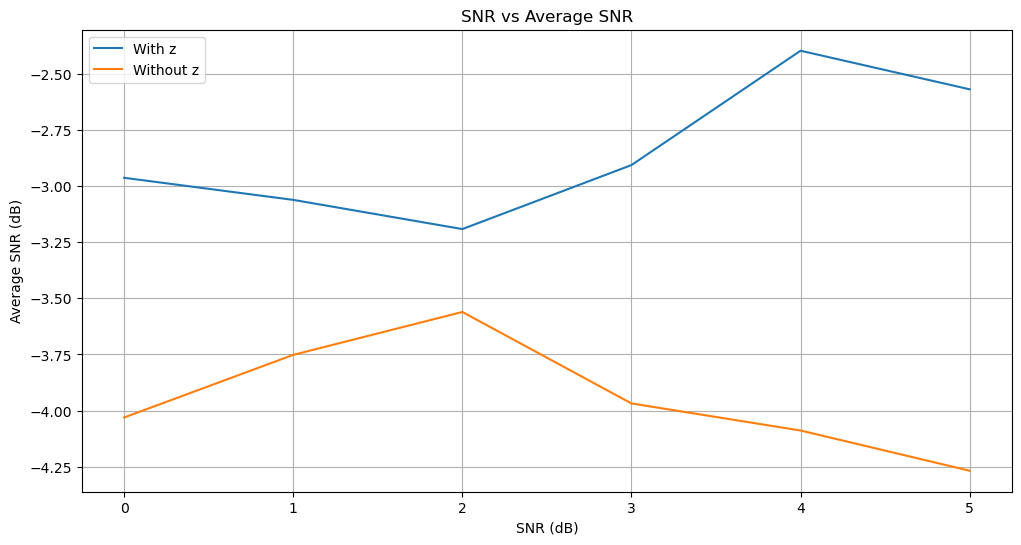

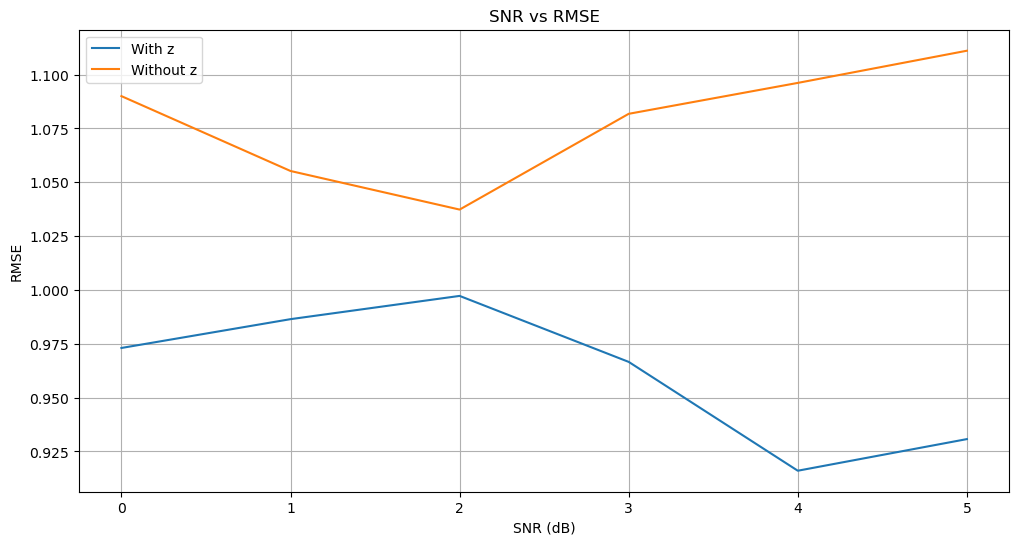

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Read the data from the text file
data = []
with open('C:\Users\\malik\\Desktop\\Disertation\\data.txt', 'r') as file:
    for line in file:
        if "With z" in line or "Without z" in line:
            model_type = "With z" if "With z" in line else "Without z"
            noise_type = re.search(r'\[(.*?)\]', line).group(1)
            snr_level = int(re.search(r'SNR (\d)', line).group(1))
            snr_value = float(re.search(r'SNR: ([\d.-]+)', line).group(1))
            rmse_value = float(re.search(r'RMSE: ([\d.-]+)', line).group(1))
            data.append({"Model_Type": model_type, "Noise_Type": noise_type, "SNR_Level": snr_level, "SNR": snr_value, "RMSE": rmse_value})

# Convert data to DataFrame
df = pd.DataFrame(data)

# Separate the data for the two models
df_with_z = df[df["Model_Type"] == "With z"]
df_without_z = df[df["Model_Type"] == "Without z"]

# Calculate average SNR and RMSE for each SNR level
avg_snr_with_z = df_with_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_with_z = df_with_z.groupby('SNR_Level')['RMSE'].mean()

avg_snr_without_z = df_without_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_without_z = df_without_z.groupby('SNR_Level')['RMSE'].mean()

# Plot SNR vs Average SNR
plt.figure(figsize=(12, 6))
plt.plot(avg_snr_with_z.index, avg_snr_with_z.values, label='With z')
plt.plot(avg_snr_without_z.index, avg_snr_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('Average SNR (dB)')
plt.title('SNR vs Average SNR')
plt.legend()
plt.grid(True)
plt.savefig('snr_vs_avg_snr.png')
plt.show()

# Plot SNR vs RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_rmse_with_z.index, avg_rmse_with_z.values, label='With z')
plt.plot(avg_rmse_without_z.index, avg_rmse_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE')
plt.title('SNR vs RMSE')
plt.legend()
plt.grid(True)
# plt.savefig('snr_vs_rmse.png')
plt.show()
